### Introduction
The purpose of this notebook is to test a hypothesis that I formulated while reading [Non-Ergodicity and its Implications for Businesses and Investors](https://fundooprofessor.wordpress.com/2019/10/13/non-ergodicity/) by Sanjay Bakshi.

The author does an excellent job of introducing the concept of Non-Ergodicity and explaining its implications for investment management (particularly position sizing). In the comments on Slide 64, he begins a discussion on the need for broad diversification (e.g., no more than ~1% of portfolio at risk in any investment). 

My hypothesis was that, since he had described a winning game, being able to participate in several similar games across a limited portfolio (size <= 15) would result in long-term wealth creation (as the author demonstrates, it doesn't work without diversification).

The notebook below has the following structure:
1. Defines the logic to recreate the game and simulate it for multiple iterations
2. Follows the author's story arc for a single-bet-per-round game (portfolio_size = 1)
3. Tests my hypothesis by creating a portfolio of similar games (portfolio_size > 1)
4. Presents the results of limited diversification

### Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Define function that recreates game and runs the simulation

In [2]:
def run_simulation(portfolio_size, num_coin_tosses, num_runs):
    """
    Runs a number of iterations of the coin tossing game defined in the PowerPoint presentation titled 
    "Non-Ergodicity and its Implications for Businesses and Investors" by Sanjay Bakshi 
    (https://fundooprofessor.wordpress.com/2019/10/13/non-ergodicity/). The game is enhanced to
    support multiple investments (portfolio_size) in the same type of game in each coin-tossing round.
    
    :param portfolio_size: Defines the number of 'investments' made in each round; allocation for each
    investment is 1 / portfolio_size.
    
    :param num_coin_tosses: Defines the number of coin tosses used in each iteration.
    
    :param num_runs: Defines the number of iterations used in the simulation.
    
    :returns: Tuple comprised of a 3-D numpy array containing the results for all coin tosses for all portfolios
    for all runs, and a pandas dataframe containing the final portfolio values for each run.
    
    :raises: :class:`AssertionError`: If any of the parameters are less than or equal to zero.
    """
    
    # validate inputs
    assert(portfolio_size >= 1)
    assert(num_coin_tosses >= 1)
    assert(num_runs >= 1)
    
    # set paramaters of "game"
    win_pct = 0.50
    loss_pct = 0.40

    initial_capital = 100
    
    # generate random numbers to simulate coin tosses
    # randint setting of 2 will generate integers 0 or 1, use 1 for heads
    coin = np.random.randint(2, size=(num_runs, num_coin_tosses, portfolio_size))
    
    # calculate change in value for tails, heads
    # when coin toss is simulated, all values of variable 'coin' will be either 0 for tails or 1 for heads
    # use value of each coin toss as index into change_in_value array below
    change_in_value = [1 - loss_pct, 1 + win_pct]

    # calculate percentage of total capital to allocate to each portfolio
    allocation = 1 / portfolio_size
    
    # create arrays to store individual outcomes and final total portfolio value after each run
    results = np.zeros(shape=(num_runs, num_coin_tosses, portfolio_size))
    portfolio_values = np.zeros(num_runs)
    
    # run simulation
    for run in range(num_runs):
        
        # cur_capital tracks changes in portfolio value after each round of coin tosses
        # reset it at the beginning of each run
        cur_capital = initial_capital
    
        for toss in range(num_coin_tosses):
            # after each round of tosses, change bet size based on current amount of capital available
            bet_size = cur_capital * allocation
            
            # toss one coin for each portfolio and calculate resulting change in total portfolio value
            for portfolio in range(portfolio_size):
                results[run, toss, portfolio] = change_in_value[coin[run, toss, portfolio]] * bet_size
                
                # current capital is sum of resulting portfolio values
                cur_capital = results[run, toss].sum()
     
        # save last portfolio value calculated for each run
        portfolio_values[run] = cur_capital
        
    # return individual results and final portfolio values (as dataframe, for easier analysis) for each run
    return results, pd.DataFrame(portfolio_values, columns=['Final Portfolio Value'])

### Run simulations with settings that follow author's story arc
In the initial slides, the author walks through the effects of a limited number of tosses from a few people. He shows that, while the average return is good (as you'd expect from a winning game), the results are skewed in ways that people don't expect (because they are focused on what the author terms the 'ensemble average').

The simulation shows similar results for 100 people making 50 coin tosses each.

In [3]:
results, port_values = run_simulation(portfolio_size = 1, num_coin_tosses = 50, num_runs = 100)

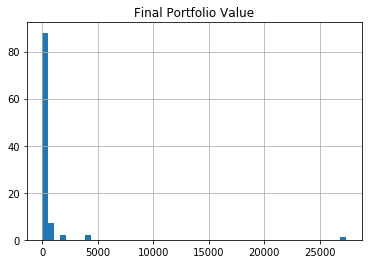

In [4]:
port_values.hist(bins=50);

In [5]:
port_values.describe()

,Final Portfolio Value
count,100.000000
mean,474.659232
std,2799.658660
min,0.004705
25%,1.148637
50%,7.178980
75%,44.868624
max,27385.634906


As the histogram and descriptive statistics demonstrate, the average value is 474.66, a return of over 374% (starting portfolio value was 100). Unfortunately, the average is skewed by a few people who made outsized gains (max portfolio value = 27,385.63). Note that the 75%-tile value is only 44.87, which means that more than 3/4 of the people who played this "winning" game lost over 55% of their initial capital, and half of the people lost more than 92%. The author presents a mathematical analysis to explain why this happens.

The author then demostrates that, because this is a non-ergodic game, everyone who plays will lose eventually. This can be seen by increasing the number of coin tosses and reviewing the results.

In [6]:
results, port_values = run_simulation(portfolio_size = 1, num_coin_tosses = 1000, num_runs = 100)

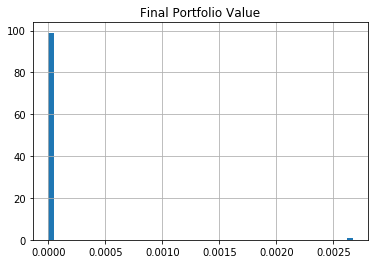

In [7]:
port_values.hist(bins=50);

In [8]:
port_values.describe()

,Final Portfolio Value
count,1.000000e+02
mean,2.669901e-05
std,2.669901e-04
min,1.636644e-39
25%,5.545167e-26
50%,5.784060e-21
75%,1.733634e-17
max,2.669901e-03


As the histogram and descriptive statistics demonstrate, the average value is now essentially zero (note that the value is of the exponent is -5), as is the maximum value (~0.0027), which means everyone lost all of their money, despite this being a "winning" game. Explaining the mathematical reasons for these results is what makes the author's presentation so intersting and valuable.

### Test my hypothesis that limited diversification should result in positive results
As the author points out, if you play a game in which you can lose 40% of your money on one coin toss, if you play long enough, you'll most likely experience a run of tails. A run of only 6 tails would mean, no matter how much you had prior to this streak, you'd lose ~95% ((1 - 40%)<sup>6</sup> = ~0.047) of your capital during this streak.

This makes sense. I hypothesized, however, that if you played a portfolio of similar games, you'd be exposed to the upside more often in each round, and, by allocating a equal amount to each portfolio, you should be able to increase the value of your portfolio.

My initial guess was that a portfolio size of 15 (meaning that 1/15 or 6.67% of your total portfolio value was allocated to each of 15 coin tosses in each round) would result in very positive returns. Here are the results...

In [9]:
results, port_values = run_simulation(portfolio_size = 15, num_coin_tosses = 1000, num_runs = 100)

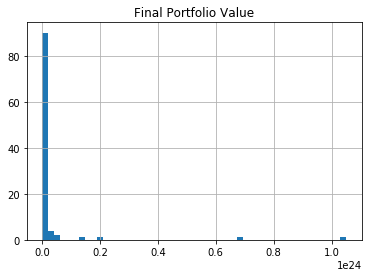

In [10]:
port_values.hist(bins=50);

In [11]:
port_values.describe()

,Final Portfolio Value
count,1.000000e+02
mean,2.430922e+22
std,1.267424e+23
min,7.721069e+16
25%,2.679200e+19
50%,2.299531e+20
75%,2.420211e+21
max,1.051054e+24


As the histogram and descriptive statistics demonstrate, even the minimum value is astronomically large. At first, I thought this was just a lucky outcome, but I re-ran the simulation 20 times, and the results were similar. I was shocked. So, I tried to find the minimum portfolio size that would result in a positive outcome.

### Present results of limited diversification
I ran a loop that would decrement the portfolio size by 1 (starting at 15). I was surprised by how small the portfolio had to be to still end up with positive results in most cases. As you can see, I increased the number of coin tosses per round and the number of runs, to ensure that I got a stable outcome (1000 coin tosses and 100 runs was fairly stable, but there was still some statistically meaningful variance). Here are the results...

In [12]:
results, port_values = run_simulation(portfolio_size = 3, num_coin_tosses = 5000, num_runs = 1000)

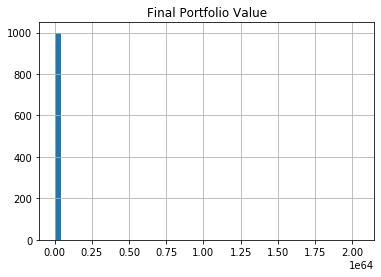

In [13]:
port_values.hist(bins=50);

In [14]:
port_values.describe()

,Final Portfolio Value
count,1.000000e+03
mean,2.050343e+61
std,6.465918e+62
min,5.082807e+10
25%,3.796720e+30
50%,1.164907e+36
75%,4.262372e+41
max,2.044701e+64


I was surprised that a portfolio size of 3 worked in all cases (the minimum value in each simulation varies, but only by the size of the positive exponent in the value). In fact, in most runs, even a portfolio_size = 2 produces positive results, but not in all re-runs of the simulation. It made me suspect that I had done something wrong, but I cannot find an error in the algorithm. I recreated the simulation in Excel by hand (copying/pasting cell formulae), and it worked the same there, so I think these findings are correct.

In the end, I'm not sure what this proves. As the author points out, diversification is important. He makes a comment on Slide 64 that concentrated portfolios (5-10 positions) should be avoided. I think these results challenge that recommendation, even if, in practical terms, such concentration cannot work for large funds due to restrictions on ownership.